# Fraud Detection with Pytorch Geometric

## Installation

In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Dataset

- Contains news propagation graphs extracted from Twitter
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Preprocessing: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features


In [2]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting ./gossipcop/raw/data.zip
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [55]:
#load new datasets for better prediction name as a1_True.csv adn a2_Fake.csv
new_real_df = pd.read_csv('a1_True.csv')
new_fake_df = pd.read_csv('a2_Fake.csv')
#print the column of new_real_df adn new_fake_df
print(new_real_df.columns)
print(new_fake_df.columns)

Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [56]:
#drop the column of text subject and date and add table of label and assign 1 for real and 0 for fake
new_real_df = new_real_df.drop(['text', 'subject', 'date'], axis=1)
new_fake_df = new_fake_df.drop(['text', 'subject', 'date'], axis=1)
new_real_df['label'] = 1
new_fake_df['label'] = 0

print(new_real_df.head())
print(new_fake_df.head())

                                               title  label
0  As U.S. budget fight looms, Republicans flip t...      1
1  U.S. military to accept transgender recruits o...      1
2  Senior U.S. Republican senator: 'Let Mr. Muell...      1
3  FBI Russia probe helped by Australian diplomat...      1
4  Trump wants Postal Service to charge 'much mor...      1
                                               title  label
0   Donald Trump Sends Out Embarrassing New Year’...      0
1   Drunk Bragging Trump Staffer Started Russian ...      0
2   Sheriff David Clarke Becomes An Internet Joke...      0
3   Trump Is So Obsessed He Even Has Obama’s Name...      0
4   Pope Francis Just Called Out Donald Trump Dur...      0


In [57]:
#concatanate the new real and fake data and do suffling
new_data = pd.concat([new_real_df, new_fake_df])
new_data = new_data.sample(frac=1).reset_index(drop=True)
print(new_data.head())

                                               title  label
0  U.S. Senate advances Iran sanctions bill, eyes...      1
1  Easily Duped: Trump Surpasses Bush, Falling fo...      0
2  WHY MOM EMPLOYED BY DISNEY Is Calling Them “Bu...      0
3  Iran, Russia and Azerbaijan call for commitmen...      1
4  Tillerson urges Iraq, Kurds to resolve conflic...      1


In [60]:
#print the shape of new data
print(new_data.shape)

(44898, 2)


In [67]:
#convert the new_data into pandas dataframe
new_data = pd.DataFrame(new_data)
#convert the new_data into torch tensor
# labels = new_data['label']
# label_tensor = torch.tensor(labels.values)
#print the label_tensor


new_df = pd.DataFrame({
    'title': new_data['title'],
    'label': new_data['label']
})
print(new_df)

                                                   title  label
0      U.S. Senate advances Iran sanctions bill, eyes...      1
1      Easily Duped: Trump Surpasses Bush, Falling fo...      0
2      WHY MOM EMPLOYED BY DISNEY Is Calling Them “Bu...      0
3      Iran, Russia and Azerbaijan call for commitmen...      1
4      Tillerson urges Iraq, Kurds to resolve conflic...      1
...                                                  ...    ...
44893   It Only Takes Chris Hayes One Tweet To Comple...      0
44894  Illinois risks rating cut to junk even with bu...      1
44895  UK PM May says takes allegations of Russian in...      1
44896  Trump taps adviser Manafort to be campaign cha...      1
44897  Ukraine says U.S. special representative will ...      1

[44898 rows x 2 columns]


##Preprocessing the newDataSet for URDF compatible formate


In [86]:
import spacy
from itertools import combinations
from torch_geometric.data import Data
import torch
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# New dataset (e.g., new_data.csv) with titles and labels
# Assume `new_data` is a Pandas DataFrame
new_data = new_df  #

# Function to convert titles into graph data
def process_text_to_graph(text, desired_feature_size=310):
    # Process text with spaCy
    doc = nlp(text)

    # Extract node features (word vectors for each token)
    node_features = [token.vector for token in doc]
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Add padding if necessary to make node features size (310)
    if node_features.size(1) < desired_feature_size:
        padding_size = desired_feature_size - node_features.size(1)
        padding = torch.zeros(node_features.size(0), padding_size)
        node_features = torch.cat([node_features, padding], dim=1)

    # Create edge index (combinations of nodes)
    num_nodes = len(node_features)
    edge_index = torch.tensor(list(combinations(range(num_nodes), 2)), dtype=torch.long).t().contiguous()

    # Create Data object for graph
    graph_data = Data(x=node_features, edge_index=edge_index)

    return graph_data

# Convert all new titles to graph data
graphs = []
for index, row in new_data.iterrows():
    graph = process_text_to_graph(row['title'])
    graph.y = torch.tensor([row['label']], dtype=torch.long)  # Assign label to graph
    graphs.append(graph)

# Now `graphs` contains all the processed graphs
# Example: Print the first graph
print(graphs[0])

# You can also create a DataLoader to batch your graph data, if needed


Data(x=[11, 310], edge_index=[2, 55], y=[1])


In [87]:
#print the shape of train adn test samples
print("Train Sample: ", train_data[0])
print("Test Sample: ", test_data[0])

Train Sample:  Data(x=[76, 310], edge_index=[2, 75], y=[1])
Test Sample:  Data(x=[116, 310], edge_index=[2, 115], y=[1])


##Splitting new Datasets as training and testing purposes

In [88]:
from sklearn.model_selection import train_test_split
# Split new data into 80% for training and 20% for testing
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

##combining new datasets with earlier one

In [89]:
#earlier train_data size
print(len(train_data))
#earlier test_data size
print(len(test_data))

1092
3826


In [90]:
test_data_list = [data for data in test_data] # Iterate over test_data to get individual Data objects
test_data_list.extend(test_graphs)
train_data_list = [data for data in train_data] # Iterate over train_data to get individual Data objects
train_data_list.extend(train_graphs)

print(len(train_data_list))
print(len(test_data_list))

37010
12806


### Investigating the News Propagation Graph

In [91]:
sample_id=1
train_data_list[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [92]:
"""
Had to import this "manually" due to some errors.
"""

!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

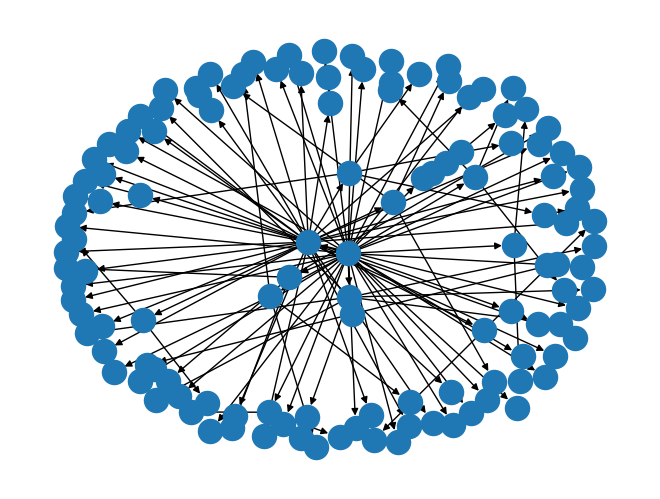

In [93]:
nx.draw(to_networkx(train_data_list[sample_id]))

### Node features

In [94]:
print(train_data_list[sample_id].x.shape)
train_data_list[sample_id].x

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

### Class distribution

<Axes: >

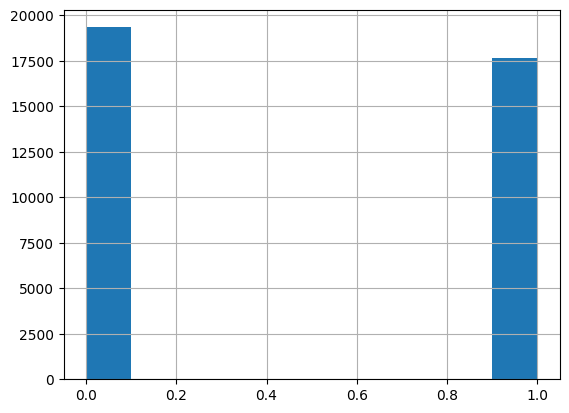

In [95]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data_list)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

### Data Loaders

In [96]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data_list, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=128, shuffle=False)

## Model and Training

--> Because it is a directed graph, it will only share information from the root

In [97]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data_list[0].num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [98]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data_list[0].num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds)).cpu().numpy()
    gts = torch.cat(gts).cpu().numpy()
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [99]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.13 | TestLoss: 0.27 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 01 |  TrainLoss: 0.08 | TestLoss: 0.24 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 02 |  TrainLoss: 0.08 | TestLoss: 0.25 | TestAcc: 0.84 | TestF1: 0.80
Epoch: 03 |  TrainLoss: 0.09 | TestLoss: 0.24 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 04 |  TrainLoss: 0.07 | TestLoss: 0.24 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 05 |  TrainLoss: 0.08 | TestLoss: 0.24 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 06 |  TrainLoss: 0.08 | TestLoss: 0.27 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 07 |  TrainLoss: 0.08 | TestLoss: 0.27 | TestAcc: 0.83 | TestF1: 0.85
Epoch: 08 |  TrainLoss: 0.08 | TestLoss: 0.25 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 09 |  TrainLoss: 0.07 | TestLoss: 0.26 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 10 |  TrainLoss: 0.07 | TestLoss: 0.24 | TestAcc: 0.84 | TestF1: 0.86
Epoch: 11 |  TrainLoss: 0.40 | TestLoss: 0.52 | TestAcc: 0.83 | TestF1: 0.79
Epoch: 12 |  TrainLoss: 0.28 | TestLoss: 0.29 | TestAcc: 0.84 | TestF1: 0.86

##SAVING MODEL


In [106]:
model_path='gnn_model2.pth'
torch.save(model.state_dict(), model_path)

In [100]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.545902   1.0     1
1    0.547609   1.0     1
2    0.547197   1.0     0
3    0.547647   1.0     1
4    0.546596   1.0     0
5    0.547494   1.0     0
6    0.546873   1.0     0
7    0.548828   1.0     1
8    0.546977   1.0     0
9    0.546774   1.0     0


#**TESTING**

In [18]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
from nltk.tokenize import word_tokenize
text = "Breaking news: Something significant happened."
tokens = word_tokenize(text.lower())


##Word embeddings

In [22]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [113]:
import spacy
from itertools import combinations
from torch_geometric.data import Data
import torch

nlp = spacy.load("en_core_web_md")

# New text (you can change this to any new text you want to process)
text = "Seven Iranians freed in the prisoner swap have not returned to Iran"
doc = nlp(text)

# Extract node features
node_features = [token.vector for token in doc]
node_features = torch.tensor(node_features, dtype=torch.float)

# Desired feature size (e.g., 300 or 310 depending on your model's requirements)
desired_feature_size = 310

# Add padding to the node features if necessary
if node_features.size(1) < desired_feature_size:
    padding_size = desired_feature_size - node_features.size(1)
    padding = torch.zeros(node_features.size(0), padding_size)
    node_features = torch.cat([node_features, padding], dim=1)

# Now node_features has the desired shape (7 nodes x 310 features in this example)
print(f"Padded node features shape: {node_features.shape}")

# Create edge index (combinations of nodes)
num_nodes = len(node_features)
edge_index = torch.tensor(list(combinations(range(num_nodes), 2))).t().contiguous()

# Create graph data
graph_data = Data(x=node_features, edge_index=edge_index)

# Print the graph data
print(graph_data)


Padded node features shape: torch.Size([12, 310])
Data(x=[12, 310], edge_index=[2, 66])


##loading the saved model


In [114]:
# Save model
# torch.save(model.state_dict(), 'gnn_model2.pth')

feature_size = 310  # Use the padded feature size (e.g., 310)
hidden_channels = 128
out_channels = 1

# Load model
model=GNN(feature_size, hidden_channels, out_channels)
model.load_state_dict(torch.load('gnn_model2.pth'))
model.eval()


<ipython-input-114-dd0553bec62d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gnn_model2.pth'))


GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)


In [116]:
# Perform prediction
with torch.no_grad():
    pred = model(graph_data.x, graph_data.edge_index, torch.zeros(graph_data.num_nodes, dtype=torch.long).to(device))

# Interpret prediction
pred_class = (pred >= 0.5).long().item()  # Convert sigmoid output to binary class
print("Predicted Class:", "Fake News" if pred_class == 1 else "Real News")


Predicted Class: Fake News
